In [1]:
import sys
import os
import os.path as op

import numpy as np
import pandas as pd
import datetime
import netCDF4 as netcdf
from datetime import timedelta
import matplotlib.dates as mdates
import matplotlib as mpl
import matplotlib.pyplot as plt
from math import pi
import xarray as xr
import glob
import math
from geopy.distance import geodesic
from scipy.interpolate import griddata

# dev library
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..'))

# dependencies
from lib import wrapSpectra, spectra, sat, plot_sat, model, fireworks, plot_storms
from lib.config import * 


# Swell Field reconstruction

Storm source identification

**Satellite tracks data - Mfwam model data**

In [2]:
# coords: (file, nbox, posneg), vars: (longitude, latitude, time)
ds_data = xr.open_dataset(op.join(p_output, 'ds_dataTracks.nc'))
ds_ww3 = xr.open_dataset(op.join(p_output, 'ww3_wind.nc'))

## CFOSAT Partitions information

Peak period and Direction of propagation given by the CFOSAT partitions information

In [3]:
#wrapSpectra.CFOSAT_partitions(ds_data, beam, min_wavelength, max_wavelength)

In [4]:
# xr.Dataset() Coords: (nbox, partition, posneg, file), Data: (SWH(m), wavelength(m), direction (°))
ds = xr.open_mfdataset(glob.glob(op.join(p_output, 'process_CFOSATparts', '*')),
                       engine='netcdf4', combine='nested', concat_dim='file', parallel=True)


In [5]:
# From ds_data and ds - > nbox, nadir, file = f (longitude, latitude)
ds = ds.load()
ds_input = xr.merge([ds_data, ds])
ds_input['Tp'] = np.sqrt(2*np.pi*ds_input['wavelength(m)']/g)
ds_input = ds_input.where((ds_input.Tp >= 16) & (ds_input['SWH(m)'] > 0.5), drop=True)
ds_input = ds_input.rename({'direction (°)':'dir', 'SWH(m)':'hs', 'wavelength(m)':'wl'})


In [6]:
ds_input = ds_input.to_dataframe().reset_index().dropna()

## Retro-propagation

All observations past-positions are calculated following geodesics at group velocity in the direction opposite to the direction of propagation until land is reached and for a maximum time of 14 days. Group velocity is estimated from dominant wavelength using linear dispersion relation, valid for swell with small steepness. (Romain)

Along this past trajectory, the fact that the generation region is detected depends on two conditions. First, a minimum number of swell observations have to converge to this region. This condition is referred to as refocusing and it is further detailed afterwards. Second, the local sea surface wind speed has to reach a threshold value compatible with the swell wavelength. Indeed, a wave of peak period Tp requires a threshold wind speed Umin
around 0.12gTp to be generated, where g is the Earth gravity. The auxiliary wind speed is given by the WW3 10m wind speed.

In practice, because of the inability of input wind data to describe the highest wind speed range, we consider a limit wind speed equal to two-thirds of Umin. Thanks to this wind speed threshold, cross sea regions occurring under calm wind conditions are rightfully rejected from the following storm detection.

In [7]:
folder = 'fireworks_PARTITIONS'
#fireworks.calculate_fireworks(ds_input, ds_ww3, folder)

In [8]:
dst = xr.open_mfdataset(glob.glob(op.join(p_output, folder, '*')),
                       engine='netcdf4', combine='nested', concat_dim='case', parallel=True)


## Refocusing regions

**Romain Husson 2012**

It is based on the analysis of retro-propagated swell density-maps over time. These densitymaps are 2D histograms indicating, for a given time step, the number of retro-propagated observations whose threshold wind speed condition is fulfilled within each cell. The density-map geographical extension covers all longitudes, and goes from 74◦S to 74◦N with 2 2◦ cells. This resolution is justified by the limited precision on the swell retro-propagated observations’ location, caused by the error on the swell peak period and direction measurements and the resulting mis-positioning after retro-propagation. In order to be able to compare density-map cells at different latitudes, each cell value is normalized by the cell surface.

**Persistency in time (24 hours)** <br>
**Density-maps at successive time steps showing the refocusing
region displacement**<br>
**Select sparce observations in time and space**

In [9]:
init = pd.Timestamp(dst.date.values.min()).round('D')
end = pd.Timestamp(dst.date.values.max()).round('D')
time = np.arange(init, end, datetime.timedelta(days=1))[::-1]

# settings
dxlon = 2
dylat = 2
xedges = np.arange(-180, 180 + 2*dxlon, dxlon)
yedges = np.arange(-90, 90 + 2*dylat, dylat)

## Refocusing 2D density maps

### The density map analysis follows an iterative process and the time series are inspected going backward in time

In [10]:
max_density = 0
for pt, tm in enumerate(time[:-1]):

    ds_delta = dst.sel(date=slice(time[pt+1], tm))
    dataframe = ds_delta.to_dataframe().reset_index().dropna()

    # histogram 2D
    Z, xedges, yedges = np.histogram2d(dataframe.lon, dataframe.lat, bins=(xedges, yedges))
    
    # calculate maxima and preserve the closest storm in time
    if Z.max() > max_density:
        max_density = Z.max()
        Tmax = tm

In [11]:
# Minimun number of observations 
th = 4
cmap = plot_storms.colormap(int(Z.max()), th)

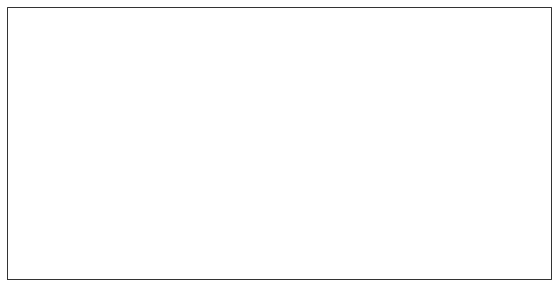

In [12]:
from matplotlib.animation import FuncAnimation
figsize=(15,5)
fig, ax = plt.subplots(figsize=figsize, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

def init():
    
    ax.add_feature(shape_feature_l) 
    return ax

def update(frame):
    
    ds_delta = dst.sel(date=slice(time[frame], time[frame+1]))
    dataframe = ds_delta.to_dataframe().reset_index().dropna()

    # histogram 2D
    Z, xed, yed = np.histogram2d(dataframe.lon, dataframe.lat, bins=(xedges, yedges))

    im = ax.contourf(xed[:-1], yed[:-1], Z.T, cmap=cmap, vmin=0, vmax=max_density, 
                     transform=ccrs.PlateCarree(), levels=20)
    ax.set_title('Storms Location \n {0}  -  {1}'.format(pd.to_datetime(str(time[frame])).strftime('%Y/%m/%d'),
                                                         pd.to_datetime(str(time[frame+1])).strftime('%Y/%m/%d'),
                                                         fontsize=15, weight='bold', pad=13))
    plt.close()
    return im,

ani = FuncAnimation(fig, update, frames=range(len(time)-1),
                    init_func=init)


In [13]:
from IPython.display import HTML
HTML(ani.to_jshtml())

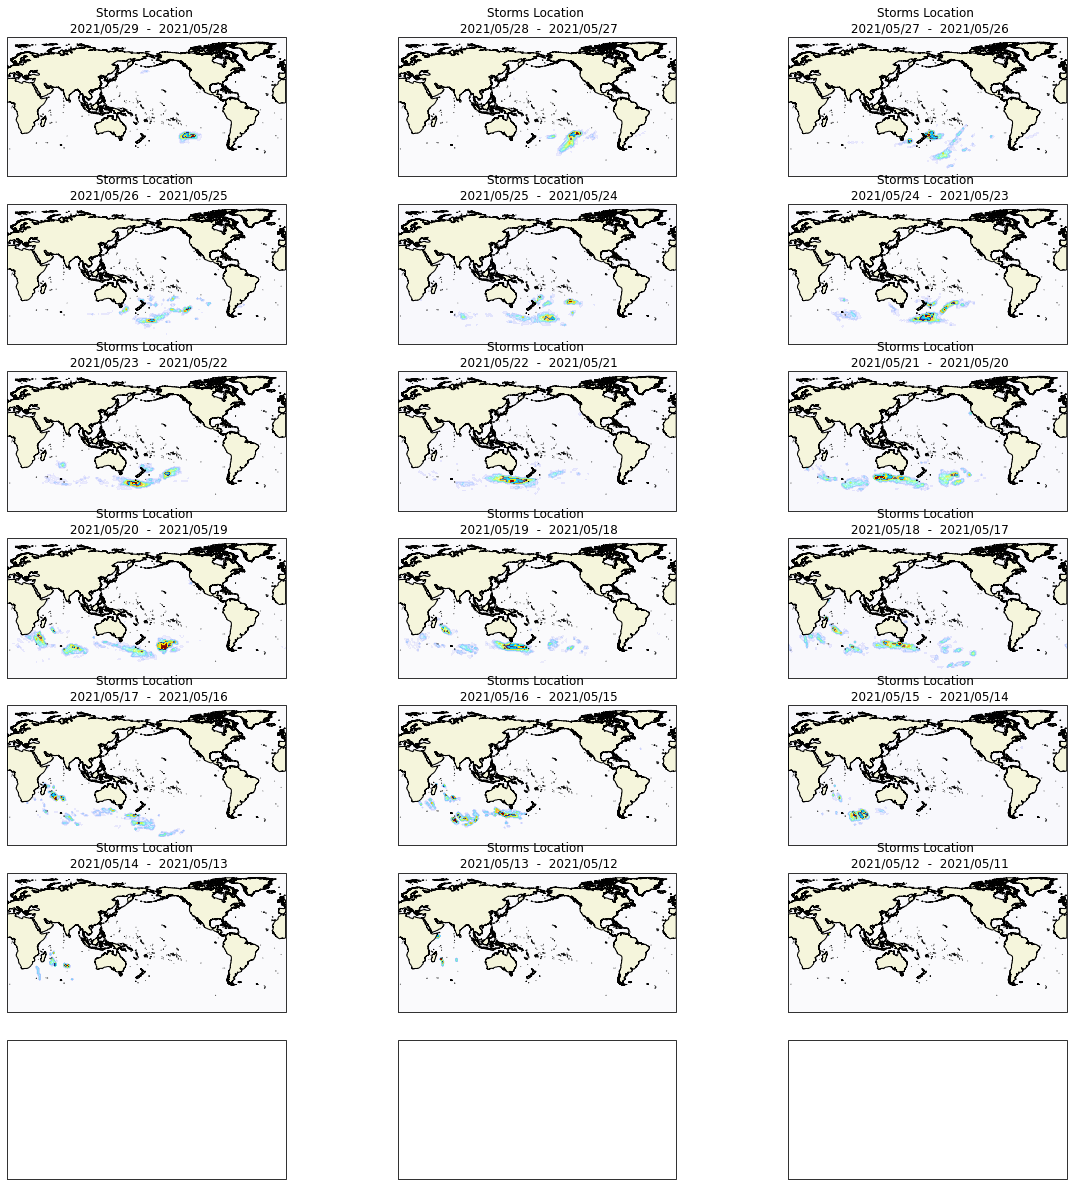

In [16]:

figsize=(21, 21)
cmap = plot_storms.colormap(int(max_density), th)
n_rows, n_cols = 7, 3
fig, (axs) = plt.subplots(
            nrows=n_rows, ncols=n_cols,
            sharex=True, sharey=True,
            constrained_layout=True,
            figsize=figsize,
            subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}
)
fig.subplots_adjust(wspace=0, hspace=0.2)
gr, gc = 0, 0
for pt, tm in enumerate(time[:-1]):

    ds_delta = dst.sel(date=slice(time[pt+1], tm))
    dataframe = ds_delta.to_dataframe().reset_index().dropna()

    # histogram 2D
    Z, xedges, yedges = np.histogram2d(dataframe.lon, dataframe.lat, bins=(xedges, yedges))

    ax = axs[gr, gc]
    ax.add_feature(shape_feature_l) 
    
    im = ax.contourf(xedges[:-1], yedges[:-1], Z.T, cmap=cmap, transform=ccrs.PlateCarree(), levels=20)
    ax.set_title('Storms Location \n {0}  -  {1}'.format(pd.to_datetime(str(tm)).strftime('%Y/%m/%d'),
                                                         pd.to_datetime(str(time[pt+1])).strftime('%Y/%m/%d'),
                                                         fontsize=15, weight='bold', pad=13))
    
    gc = gc + 1
    if gc == n_cols:
        gc = 0
        gr = gr +1
# plt colorbar
#axc, loc = plot_sat.add_colorbar(ax)
#fig.add_axes(axc)
#ax.set_extent([-180, 180, -90, 90])
#plt.colorbar(im, cax=axc, label='Observations density')
#ax.grid('on')
plt.show()

In [10]:
# create datetime colorbar
cmap = plt.cm.rainbow  
t = mdates.date2num(dataframe.date)

figsize=(21, 21)
fig, ax = plot_sat.map_init(figsize)
ax = plot_sat.map_settings(ax)
ax.add_feature(shape_feature_l)

# plot past observations
im = ax.scatter(dataframe.lon, dataframe.lat, c=t, 
                s=5, cmap=cmap, transform=ccrs.PlateCarree(), zorder=2)

ax.set_title('CFOSAT fireworks \n {0}  -  {1}'.format(time_range[0].strftime('%d %B %Y'), time_range[1].strftime('%d %B %Y')), fontsize=15, weight='bold', pad=13)

# plt colorbar
axc, loc = plot_sat.add_colorbar(ax)
fig.add_axes(axc)
cb = plt.colorbar(im, cax=axc, ticks=loc,
             format=mdates.AutoDateFormatter(loc),)# extend='min'
cb.set_label(label='Travel Date', size='large', weight='bold')
#ax.legend(title='Hs(m)', fontsize=15)
plt.show()
